<a href="https://colab.research.google.com/github/srishtipithadia/ProjectsInMLandAI/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

**Final Project: Treatment Price Prediction**

*   By: Sai Avula & Srishti Pithadia
*   Date: December 1st, 2022

---


**Task 1: Describe the Problem**

The goal of this project is to examine the relationship between the prices of a specific treatments at different hospitals (with coverage under Medicare or Medicaid). We hope to determine whether some factors are more important than others in determining the cost of treatment (for example, maybe location), and if these observations will ultimately allow us to predict the cost of a certain treatment. This is a problem that can be solved with machine learning/artificial intelligence because it fits the requirements for using a neural network. There are 500,000+ data points available to analyze and there’s also 10+ input features. Additionally, the target variable (the price of treatment) is a continuous variable, making this a complex problem to solve and an ideal application of a neural network for making predictions.

**Task 2: Pick the Dataset**

In [ ]:
# installing necessary resources
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import random
import math
import pickle

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow import keras
from keras.losses import MeanSquaredLogarithmicError, MeanSquaredError
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn import model_selection as ms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from google.colab import drive

# connect to Google Drive where compressed dataset has been uploaded
drive.mount('/content/gdrive')

<ipython-input-2-a86c0dad6438>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We found the dataset at the following link:
[https://www.kaggle.com/datasets/natesutton/hospitalpricetransparency?select=price.csv](https://www.kaggle.com/datasets/natesutton/hospitalpricetransparency?select=price.csv)

We chose this dataset because it's relevant to our problem, and it's specific enough to hopefully yield a good accuracy score. By focusing on only the state of North Carolina, the data is not noisy and cluttered with more information than we can handle. This was the issue with the first dataset we originally selected:
[https://www.kaggle.com/datasets/jpmiller/healthcare?select=hospital_prices.csv](https://www.kaggle.com/datasets/jpmiller/healthcare?select=hospital_prices.csv)

It was 32GB and more than we could handle. It was such a struggle to get it to even just open in Colab! From this experience though, we revised our original plan and decided to focus on a particular region. In this case, our dataset would represent North Carolina. Additionally, this dataset is even better than others we looked at because instead of using 2 different categorization formats (HCPCS and CPT, which we'll go into more later), this dataset only uses the HCPCS format. Less to translate means less unnecessary data that needs to be loaded in and then removed later.

In [ ]:
# unzip the compressed dataset
!unzip gdrive/My\ Drive/hospital_price_data.zip

Archive:  gdrive/My Drive/hospital_price_data.zip
replace concept.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: concept.csv             
replace hospital.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hospital.csv            
replace price.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: price.csv               


In [ ]:
# load up dataset #1
df1 = pd.read_csv('concept.csv')

# viewing the first few rows of the data
print(df1.shape)
df1.head()

(10793, 4)


,concept_id,concept_code,vocabulary_id,concept_name
0,43533189,CH,HCPCS,"0 percent impaired, limited or restricted"
1,43533250,CN,HCPCS,"100 percent impaired, limited or restricted"
2,40664799,G8707,HCPCS,"12-lead electrocardiogram (ecg) not performed,..."
3,40664798,G8704,HCPCS,12-lead electrocardiogram (ecg) performed
4,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c..."


This dataset represents the Athena identifier as "concept_id", the source code as "concept_code", whether it's HCPCS or CPT as "vocabulary_id", and the human-readable name as "concept_name". 

HCPCS stands for "Healthcare Common Procedure Coding System Codes" and CPT stands for "Current Procedural Terminology". These lists identify all items/services that are included within certain DHS (Demographic & Health Survey) categories, as well as those that may qualify for certain exceptions. The DHS categories that are included in these lists are the following:

1. Clinical Laboratory Services
2. Physical Therapy Services
3. Occupational Therapy Services
4. Outpatient Speech-Language Pathology Services
5. Radiology/Other Imaging Services
6. Radiation Therapy Services/Supplies
7. Durable Medical Equipment/Supplies
8. Parenteral/Enteral Nutrients/Equipment/Supplies
9. Prosthetics, Orthotics, and Prosthetic Devices/Supplies
10. Home Health Services
11. Outpatient Prescription Drugs
12. Inpatient/Outpatient Hosptial Services

And the exceptions mentioned above fall within the following categories:
1. EPO & Other Dialysis-Related Drugs
2. Preventative Screening Tests/Vaccines

This information is outlined [here](https://www.cms.gov/medicare/fraud-and-abuse/physicianselfreferral/list_of_codes) at the CMS (Centers for Medicare & Medicaid Services) website. They are the organization that requires hospitals to publish lists of prices on their websites. Unfortunately though, the CMS doesn't have strong guidance on formatting (which is why HCPCS and CPT both exist simultaneously). Hospital pricing is then cluttered with noise purposfully introduced by hospital systems to be not consumer friendly.

In [ ]:
# load up dataset #2
df2 = pd.read_csv('hospital.csv')

# viewing the first few rows of the data
print(df2.shape)
df2.head()

(115, 8)


,hospital_id,hospital_name,hospital_npi,city,state,critical_access_ind,affiliation,disclosure
0,1,CarolinaEast Medical Center,1801852835,New Bern,NC,0,Independent,https://apps.para-hcfs.com/PTT/FinalLinks/Caro...
1,2,Carteret Health Care,1760479331,Morehead City,NC,0,Independent,https://www.carterethealth.org/documents/conte...
2,3,Catawba Valley Medical Center,1164495255,Hickory,NC,0,Independent,https://www.catawbavalleyhealth.org/documents/...
3,4,Dosher Memorial Hospital,1326589649,Southport,NC,1,Independent,NaN
4,5,Granville Medical Center,1326061730,Oxford,NC,0,Independent,https://www.ghshospital.org/Content/Uploads/Gr...


This next dataset contains the name of the hospital as "hospital_name", their NPI (National Provider Identifier) as "hospital_npi", their city and state, whether they're critical access hospitals as "critical_access_ind", their group as "affiliation", and their disclosure as "disclosure".

The NPI is a HIPAA administration simplification standard, and is a unique ID number for covered health care providers. A critical access hospital is a desigation that reduces the financial vulnerability of rural hospitals to improve access to healthcare. They receive benefits like cost-based reimbursement for Medicare services. Affiliation refers to the group the hospital belongs to. Some hospitals can be independent, while a certian hospital group refers to the facilities/assets/operations all of acquired entities that are related to a hospital. Finally, a disclosure outlines how a hospital handles a patient's information.  

In [ ]:
# load up dataset #3
df3 = pd.read_csv('price.csv')

# viewing the first few rows of the data
print(df3.shape)
df3.head()

(1507795, 4)


,hospital_id,concept_id,price,amount
0,1,2101826,gross,6147.00
1,1,2101827,gross,9221.00
2,1,40757009,gross,13614.00
3,1,40756966,gross,16559.00
4,1,32598,gross,10.69


This final dataset contains the price type of the service as "price", and the cost of the service (in USD) as "amount".

There are 4 options for the "price" column, which are the following:

1. Gross
2. Cash
3. Max Negotiated Rate
4. Min Negotiated Rate

The "gross" price type is often the top line item that the hospital never actually charges. The "cash" price type is the self-pay discounted price one would pay without insurance. The "max negotiated rate" price type is the maximum negotiated rate by an insurance company in the hospital network. Finally, the "min negotiated rate" price type is the minimum negotiated rate by an insurance company in the hospital network.

**Task 3: Prepare the Dataset**

In [ ]:
# making "gross", "price", "max", and "min" each their own columns
for column in ['price']:
    dummies = pd.get_dummies(df3[column])
    df3 = pd.concat([df3, dummies], axis=1).drop([column], axis=1)

# converting the column types so they all match
df3["max"] = df3["max"].astype("float64")
df3["min"] = df3["min"].astype("float64")

# viewing new column style
df3.head()

,hospital_id,concept_id,amount,cash,gross,max,min
0,1,2101826,6147.00,0,1,0.0,0.0
1,1,2101827,9221.00,0,1,0.0,0.0
2,1,40757009,13614.00,0,1,0.0,0.0
3,1,40756966,16559.00,0,1,0.0,0.0
4,1,32598,10.69,0,1,0.0,0.0


In [ ]:
# substituting the 0/1 values from the hot encoding with the "amount" dollar values

# making lists of the values for every row of "gross", "price", "max", and "min"
cash, gross, maxl, minl = [], [], [], []

for ind, row in df3.iterrows():
  if row['cash'] == 1:
    cash.append(row['amount'])
    gross.append(0)
    maxl.append(0)
    minl.append(0)

  elif row['gross'] == 1:
    cash.append(0)
    gross.append(row['amount'])
    maxl.append(0)
    minl.append(0)

  elif row['max'] == 1:
    cash.append(0)
    gross.append(0)
    maxl.append(row['amount'])
    minl.append(0)

  elif row['min'] == 1:
    cash.append(0)
    gross.append(0)
    maxl.append(0)
    minl.append(row['amount'])

# setting the new values for "gross", "price", "max", and "min"
df3['cash'] = cash
df3['gross'] = gross
df3['max'] = maxl
df3['min'] = minl

# remove "amount" column now that it's unnecessary
df3.drop(['amount'], axis=1, inplace=True)

# viewing the new formatted table
df3.head()

,hospital_id,concept_id,cash,gross,max,min
0,1,2101826,0.0,6147.00,0.0,0.0
1,1,2101827,0.0,9221.00,0.0,0.0
2,1,40757009,0.0,13614.00,0.0,0.0
3,1,40756966,0.0,16559.00,0.0,0.0
4,1,32598,0.0,10.69,0.0,0.0


In [ ]:
# viewing the new formatted table
df3.tail()

,hospital_id,concept_id,cash,gross,max,min
1507790,99,2721967,17.4,0.0,0.0,0.0
1507791,99,2721974,4521.0,0.0,0.0,0.0
1507792,99,2721974,2986.2,0.0,0.0,0.0
1507793,99,2721975,39.0,0.0,0.0,0.0
1507794,99,2721977,18.0,0.0,0.0,0.0


In [ ]:
# combining rows with the same "hospital_id" and "concept_id"
# this allows "cash", "gross", "max" and "min" values to all show up in one row
df3 = (df3.groupby(['hospital_id','concept_id']).agg(cash_t=('cash', 'sum'), gross_t=('gross', 'sum'), max_t=('max', 'sum'), min_t=('min', 'sum')).reset_index())

In [ ]:
# merging all 3 datasets on "hospital_id" and "concept_id"
df = pd.merge(df1, pd.merge(df2, df3))

# viewing the first few rows of the combined data
# verify that "gross", "price", "max" and "min" column values converted successfully
print(df.shape)
df.head()

(26781, 16)


,concept_id,concept_code,vocabulary_id,concept_name,hospital_id,hospital_name,hospital_npi,city,state,critical_access_ind,affiliation,disclosure,cash_t,gross_t,max_t,min_t
0,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",10,Sampson Regional Medical Center,1609857432,Clinton,NC,0,Independent,https://apps.para-hcfs.com/PTT/FinalLinks/Samp...,74.20,106.00,97.52,67.52
1,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",41,CaroMont Regional Medical Center,1013918960,Gastonia,NC,0,CaroMont Health,https://www.caromonthealth.org/documents/56-06...,63.75,182.15,173.04,23.00
2,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",48,Duke Raleigh Hospital,1205150380,Raleigh,NC,0,Duke Health,https://www.dukehealth.org/sites/default/files...,39.20,140.00,106.40,0.00
3,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",49,Duke Regional Hospital,1871592113,Durham,NC,0,Duke Health,https://www.dukehealth.org/sites/default/files...,39.20,140.00,103.88,0.00
4,40218804,U0002,HCPCS,"2019-ncov coronavirus, sars-cov-2/2019-ncov (c...",50,Duke University Hospital,1306013552,Durham,NC,0,Duke Health,https://www.dukehealth.org/sites/default/files...,39.20,140.00,226.07,0.00


**Task 4: Exploratory Data Analysis**

In [ ]:
# getting general info about the dataset's columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26781 entries, 0 to 26780
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   concept_id           26781 non-null  int64  
 1   concept_code         26781 non-null  object 
 2   vocabulary_id        26781 non-null  object 
 3   concept_name         26781 non-null  object 
 4   hospital_id          26781 non-null  int64  
 5   hospital_name        26781 non-null  object 
 6   hospital_npi         26781 non-null  int64  
 7   city                 26781 non-null  object 
 8   state                26781 non-null  object 
 9   critical_access_ind  26781 non-null  int64  
 10  affiliation          26781 non-null  object 
 11  disclosure           26059 non-null  object 
 12  cash_t               26781 non-null  float64
 13  gross_t              26781 non-null  float64
 14  max_t                26781 non-null  float64
 15  min_t                26781 non-null 

In [ ]:
# looking at the stats of the dataset's numerical columns
df.describe()

,concept_id,hospital_id,hospital_npi,critical_access_ind,cash_t,gross_t,max_t,min_t
count,2.678100e+04,26781.000000,2.678100e+04,26781.000000,2.678100e+04,2.678100e+04,2.678100e+04,2.678100e+04
mean,8.204465e+06,57.032560,1.428789e+09,0.167581,2.522662e+04,6.426467e+04,2.175506e+06,9.163009e+03
std,1.392214e+07,27.868587,2.438214e+08,0.373501,1.022840e+06,2.067025e+06,1.320642e+08,2.801591e+05
min,7.040550e+05,1.000000,1.013919e+09,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.615863e+06,32.000000,1.265088e+09,0.000000,0.000000e+00,1.188000e+01,0.000000e+00,0.000000e+00
50%,2.718556e+06,64.000000,1.376708e+09,0.000000,2.464000e+01,4.646600e+02,2.812000e+02,1.210000e+00
75%,2.720446e+06,76.000000,1.548276e+09,0.000000,7.189800e+02,3.890650e+03,3.925330e+03,5.800000e+02
max,4.589082e+07,111.000000,1.972001e+09,1.000000,1.110429e+08,2.220858e+08,1.037767e+10,3.356972e+07


In [ ]:
# looking at stats of the dataset's categorical columns
df.describe(include=['O'])

,concept_code,vocabulary_id,concept_name,hospital_name,city,state,affiliation,disclosure
count,26781,26781,26781,26781,26781,26781,26781,26059
unique,2610,1,2596,54,48,1,10,45
top,C1751,HCPCS,"Drug test(s), definitive, utilizing (1) drug i...",Duke Regional Hospital,Charlotte,NC,Novant Health,https://www.cdmpricing.com/148edeae6e4a2870490...
freq,50,26781,82,987,1689,26781,5797,2142


In [ ]:
# checking for duplicate rows
dup_df = df[df.duplicated()]
dup_df.shape[0]

0

a. Handling Null Values

In [ ]:
# checking to see if there are any missing vals in the dataset
df.isnull().sum()

concept_id               0
concept_code             0
vocabulary_id            0
concept_name             0
hospital_id              0
hospital_name            0
hospital_npi             0
city                     0
state                    0
critical_access_ind      0
affiliation              0
disclosure             722
cash_t                   0
gross_t                  0
max_t                    0
min_t                    0
dtype: int64

In [ ]:
# dropping "disclosure" column because it's all URLs, isn't relevant, and contains nulls
df.drop(['disclosure'], axis=1, inplace=True)
print("remaining N/A's: \n", df.isnull().sum())

remaining N/A's: 
 concept_id             0
concept_code           0
vocabulary_id          0
concept_name           0
hospital_id            0
hospital_name          0
hospital_npi           0
city                   0
state                  0
critical_access_ind    0
affiliation            0
cash_t                 0
gross_t                0
max_t                  0
min_t                  0
dtype: int64


In [ ]:
num_concept_codes = len(pd.unique(df['concept_code']))
print("There are {} concepts in the dataset".format(num_concept_codes))

There are 2610 concepts in the dataset


In [ ]:
#Standard deviations for each of the price columns
print("The standard deviation of max_t is {}".format(df.max_t.std()))
print("The standard deviation of min_t is {}".format(df.min_t.std()))
print("The standard deviation of gross_t is {}".format(df.gross_t.std()))
print("The standard deviation of cash_t is {}".format(df.cash_t.std()))

The standard deviation of max_t is 132064180.59989814
The standard deviation of min_t is 280159.0973446418
The standard deviation of gross_t is 2067025.2875592597
The standard deviation of cash_t is 1022839.5685792057


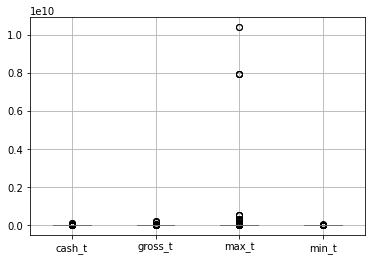

In [ ]:
#boxplot
boxplot = df.boxplot(column=['cash_t', 'gross_t', 'max_t', 'min_t'])

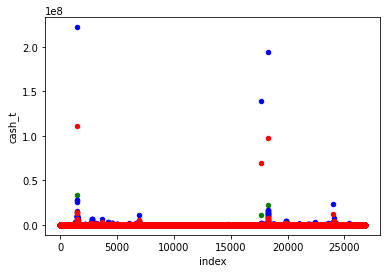

In [ ]:
#scatter plots of price values
temp_df = df.reset_index()
ax1 = temp_df.plot(kind='scatter', x='index', y='min_t', color='g')    
ax2 = temp_df.plot(kind='scatter', x='index', y='gross_t', color='b', ax=ax1)
ax3 = temp_df.plot(kind='scatter', x='index', y='cash_t', color='r', ax=ax1)

From the above visualizations and standard deviation calculations, it can be determined that there are outliers skewing the price values. We will filter out the outliers for each price category using percentile rankings.

In [ ]:
temp_df['PR_max'] = temp_df.max_t.rank(pct = True)
temp_df['PR_min'] = temp_df.min_t.rank(pct = True)
temp_df['PR_cash'] = temp_df.cash_t.rank(pct = True)
temp_df['PR_gross'] = temp_df.gross_t.rank(pct = True)

In [ ]:
remove_outliers = temp_df[temp_df["PR_max"] < .95]
remove_outliers = remove_outliers[remove_outliers["PR_min"] < .95]
remove_outliers = remove_outliers[remove_outliers["PR_cash"] < .95]
remove_outliers = remove_outliers[remove_outliers["PR_gross"] < .95]

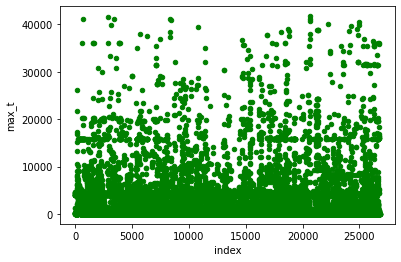

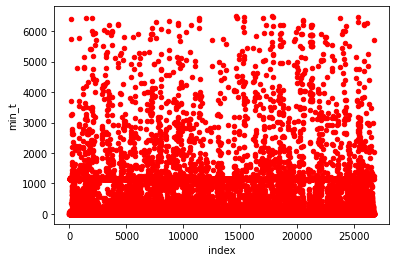

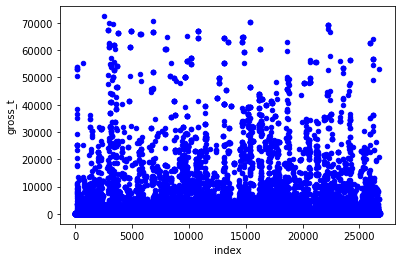

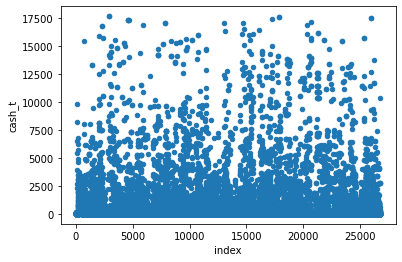

In [ ]:
remove_outliers.plot(kind='scatter', x='index', y='max_t', color='g')
remove_outliers.plot(kind='scatter', x='index', y='min_t', color='r')   
remove_outliers.plot(kind='scatter', x='index', y='gross_t', color='b')  
remove_outliers.plot(kind='scatter', x='index', y='cash_t')  

In [ ]:
#removing outliers from dataset used for processing
df = remove_outliers

In [ ]:
means = df.groupby("affiliation").mean()
means

,index,concept_id,hospital_id,hospital_npi,critical_access_ind,cash_t,gross_t,max_t,min_t,PR_max,PR_min,PR_cash,PR_gross
affiliation,,,,,,,,,,,,,
Appalachian Regional Healthcare System,13409.815488,7.800938e+06,12.543021,1.533219e+09,0.456979,1619.640067,3239.273250,2822.720698,256.507390,0.599533,0.567760,0.698033,0.564305
Atrium Health,13420.882137,8.050967e+06,28.809739,1.372470e+09,0.000000,1803.630527,2275.854249,2717.728371,636.468805,0.519581,0.597198,0.700160,0.382689
CaroMont Health,13455.217970,8.320586e+06,41.000000,1.013919e+09,0.000000,1443.339933,4123.819301,3898.443145,422.242246,0.627826,0.656418,0.690323,0.587652
Duke Health,12268.675193,5.708178e+06,49.074360,1.592073e+09,0.000000,1336.988430,4774.957942,3649.761820,0.000000,0.632922,0.244800,0.699534,0.622910
FirstHealth,13642.783658,7.888211e+06,62.554864,1.414894e+09,0.222568,0.000000,6622.822032,0.000000,0.000000,0.187204,0.244800,0.228819,0.599730
HCA,13429.293295,8.285131e+06,67.503822,1.445016e+09,0.658877,0.000000,7377.326528,0.000000,0.000000,0.187204,0.244800,0.228819,0.586828
Independent,13131.071588,7.597220e+06,3.422819,1.715891e+09,0.000000,780.009165,2845.505444,1196.229553,418.434795,0.433937,0.531429,0.521834,0.521415
Novant Health,13870.762242,9.721058e+06,78.772035,1.425873e+09,0.014871,241.374955,906.276085,4678.334815,603.415386,0.698584,0.618038,0.355078,0.265904
UNC Health,13008.991014,8.716178e+06,97.833119,1.541406e+09,0.014121,887.401694,1479.002529,1431.491412,636.248151,0.552396,0.686316,0.663187,0.498280


As seen in the grouping by affiliation of hospitals, the HCA and FirstHealth groups do not have values for the max and min negotiated rates, as well as cash prices. Since gross is not very informative since this price is not usually paid ever by the patient or payer, we will remove HCA and FirstHealth from the processed dataset.

In [ ]:
df = df.loc[(df['affiliation'] != 'HCA') & (df['affiliation'] != 'FirstHealth')]

In [ ]:
print("There are {} prices in the dataset after removing HCA and FIrstHealth".format(len(df)))

There are 17011 prices in the dataset after removing HCA and FIrstHealth


b. Visualizing the Data

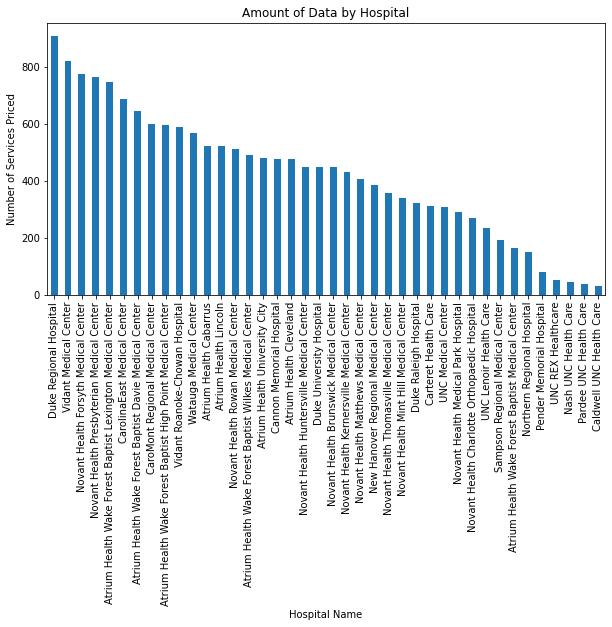

In [ ]:
# looking for the amount of data relevant to each hospital
df['hospital_name'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Amount of Data by Hospital")
plt.ylabel('Number of Services Priced')
plt.xlabel('Hospital Name');

Text(0.5, 1.0, 'affiliation')

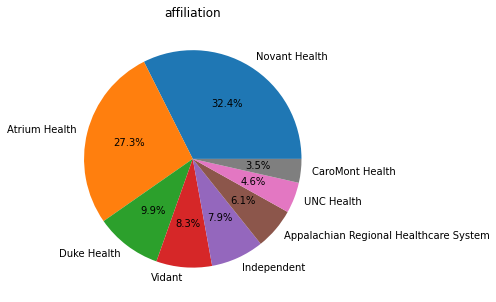

In [ ]:
# looking for the split of hospital groups (if affiliated) in the dataset
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['affiliation'].value_counts(), 
       labels=df['affiliation'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('affiliation')

Text(0.5, 1.0, 'state')

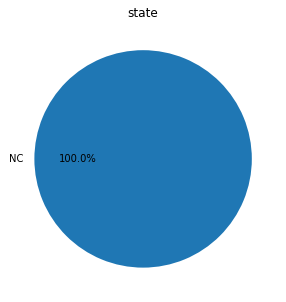

In [ ]:
# looking for the state location split of the hospitals
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['state'].value_counts(), 
       labels=df['state'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('state')

In [ ]:
# looking at the unique NC cities in the dataset
print(df['city'].unique())

['Clinton' 'Gastonia' 'Raleigh' 'Durham' 'Supply' 'Charlotte'
 'Winston-Salem' 'Huntersville' 'Kernersville' 'Matthews' 'Mint Hill'
 'Salisbury' 'Thomasville' 'Greenville' 'Ahoskie' 'New Bern' 'High Point'
 'Lexington' 'North Wilkesboro' 'Morehead City' 'Linville' 'Boone'
 'Concord' 'Shelby' 'Lincolnton' 'Bermuda Run' 'Mount Airy' 'Chapel Hill'
 'Wilmington' 'Kinston' 'Burgaw' 'Hendersonville' 'Lenoir' 'Rocky Mount'
 'Goldsboro' 'Eden' 'Smithfield' 'Siler City']


Text(0.5, 1.0, 'critical_access_ind')

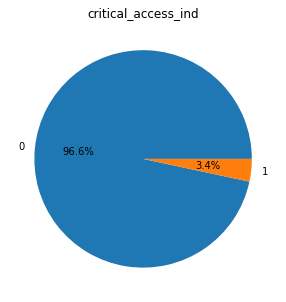

In [ ]:
# looking for the split of critical access hospitals
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['critical_access_ind'].value_counts(), 
       labels=df['critical_access_ind'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('critical_access_ind')

In [ ]:
# looking for which hospitals are critical access hospitals & where they're located
df[['hospital_id', 'hospital_name', 'city', 'critical_access_ind']].groupby(['hospital_id', 'hospital_name', 'city'], as_index=False).mean().sort_values(by='critical_access_ind', ascending=False)

,hospital_id,hospital_name,city,critical_access_ind
33,92,Chatham UNC Health Care,Siler City,1.0
4,12,Cannon Memorial Hospital,Linville,1.0
30,86,Pender Memorial Hospital,Burgaw,1.0
0,1,CarolinaEast Medical Center,New Bern,0.0
25,79,Novant Health Medical Park Hospital,Winston-Salem,0.0
26,80,Novant Health Mint Hill Medical Center,Mint Hill,0.0
27,81,Novant Health Presbyterian Medical Center,Charlotte,0.0
28,82,Novant Health Rowan Medical Center,Salisbury,0.0
29,83,Novant Health Thomasville Medical Center,Thomasville,0.0
31,87,New Hanover Regional Medical Center,Wilmington,0.0


Text(0.5, 1.0, 'vocabulary_id')

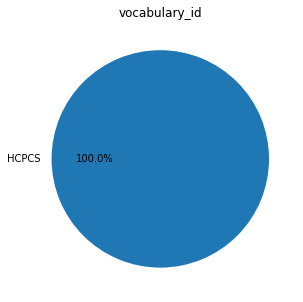

In [ ]:
# looking for the split of the list type
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df['vocabulary_id'].value_counts(), 
       labels=df['vocabulary_id'].value_counts().index,
       autopct='%1.1f%%')
ax.set_title('vocabulary_id')

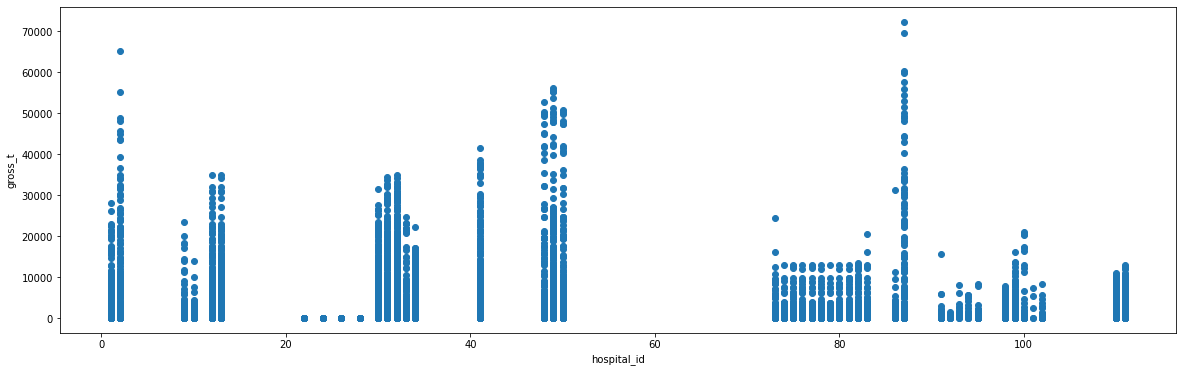

In [ ]:
# seeing the distribution of gross prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['gross_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('gross_t')
plt.show()

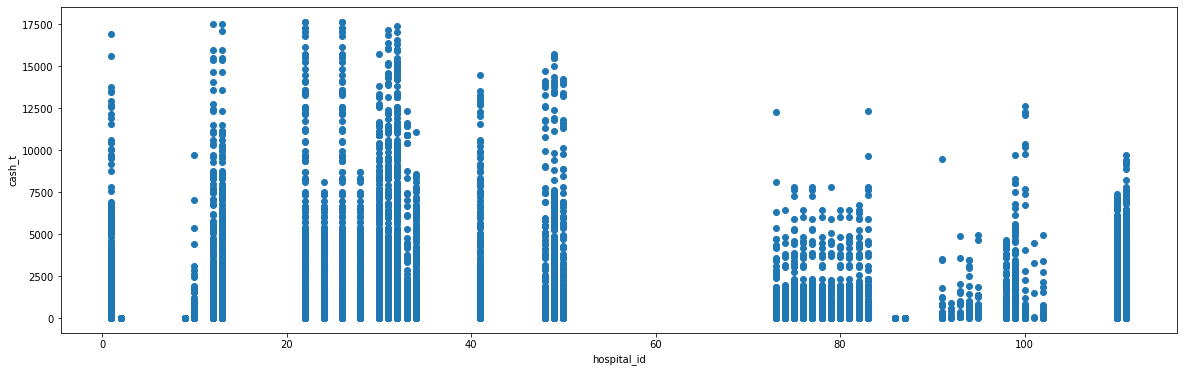

In [ ]:
#seeing the distribution of cash prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['cash_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('cash_t')
plt.show()

Just visually, it seems like the same hospitals that have some of the highest gross costs have higher cash costs than the hospitals which have similar gross costs. It's worth looking into what kinds of treatments have these prices, because maybe they are not offered at many hospitals. Highly specialized services would justify the kinds of outliers that we're seeing above.

In [ ]:
# viewing all service concepts in the dataset by gross cost
df[['concept_code', 'concept_name', 'gross_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='gross_t', ascending=False)

,concept_code,concept_name,gross_t
360,C2616,"Brachytherapy source, non-stranded, yttrium-90...",72423.000000
1888,L5858,"Addition to lower extremity prosthesis, endosk...",55355.290000
200,A9543,"Yttrium y-90 ibritumomab tiuxetan, therapeutic...",53020.675919
1904,L5973,"Endoskeletal ankle foot system, microprocessor...",51243.520000
347,C1891,"Infusion pump, non-programmable, permanent (im...",50412.320000
...,...,...,...
491,D1110,PROPHYLAXIS-ADULT,0.000000
490,D0475,DECALCIFICATION PROCEDURE,0.000000
489,D0470,DIAGNOSTIC CASTS,0.000000
488,D0320,TEMPOROMANDIBULAR JOINT ARTHROGRAM,0.000000


In [ ]:
# viewing all service concepts in the dataset by cash cost
df[['concept_code', 'concept_name', 'cash_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='cash_t', ascending=False)

,concept_code,concept_name,cash_t
473,C9754,"Creation of arteriovenous fistula, percutaneou...",17314.0500
474,C9755,"Creation of arteriovenous fistula, percutaneou...",17314.0500
575,E0747,"Osteogenesis stimulator, electrical, non-invas...",16378.7875
1888,L5858,"Addition to lower extremity prosthesis, endosk...",15499.4800
1904,L5973,"Endoskeletal ankle foot system, microprocessor...",14348.1900
...,...,...,...
523,D2954,PREFABRICATED POST AND CORE IN ADDITION TO CROWN,0.0000
524,D2999,UNSPECIFIED RESTORATIVE PROCEDURE,0.0000
2249,Q4114,"Integra flowable wound matrix, injectable, 1 cc",0.0000
525,D3110,PULP CAP-DIRECT (EXCLUDING FINAL RESTORATION),0.0000


From the above tables, we can see that they are fairly consistent with each other. The high gross and cash values are for prostheses and foot treatments. The lower cash costs are for adjustments

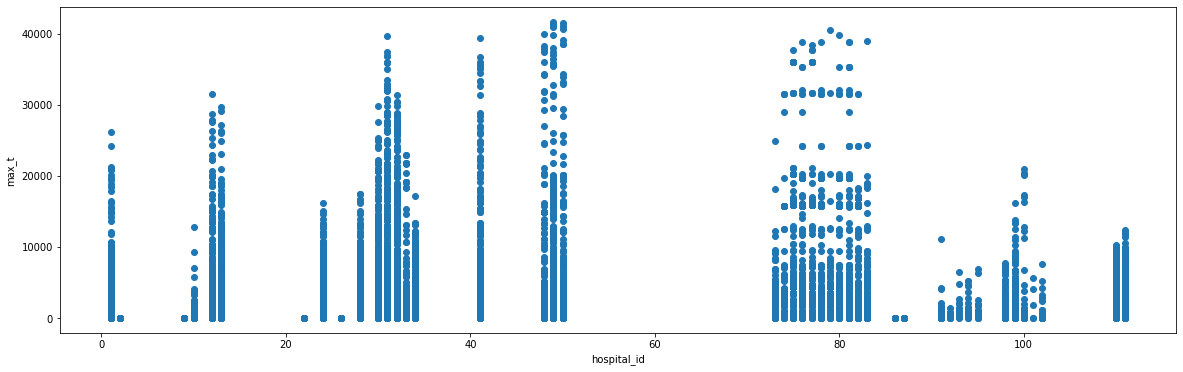

In [ ]:
# seeing the distribution of max prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['max_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('max_t')
plt.show()

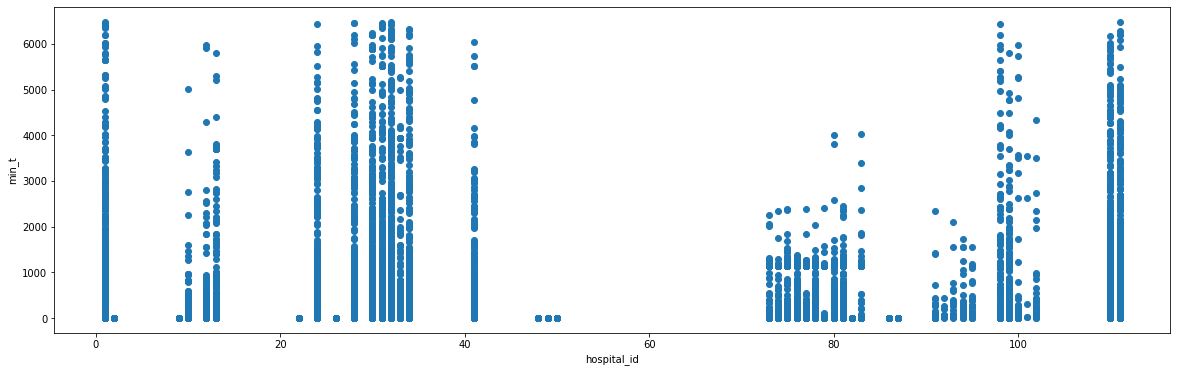

In [ ]:
# seeing the distribution of min prices by hospital
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(df['hospital_id'], df['min_t'])
ax.set_xlabel('hospital_id')
ax.set_ylabel('min_t')
plt.show()

Alternatively, the max costs and min costs don't seem to show a direct correlation, as gross costs and cash costs did. 

In [ ]:
# viewing all service concepts in the dataset by max cost
df[['concept_code', 'concept_name', 'max_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='max_t', ascending=False)

,concept_code,concept_name,max_t
1888,L5858,"Addition to lower extremity prosthesis, endosk...",41073.630000
347,C1891,"Infusion pump, non-programmable, permanent (im...",38935.113333
1904,L5973,"Endoskeletal ankle foot system, microprocessor...",38022.690000
575,E0747,"Osteogenesis stimulator, electrical, non-invas...",36954.275000
2041,L6975,"Interscapular-thoracic, external power, molded...",35936.860000
...,...,...,...
656,G0422,Intensive cardiac rehabilitation; with or with...,0.000000
657,G0423,Intensive cardiac rehabilitation; with or with...,0.000000
662,G0431,"Drug screen, qualitative; multiple drug classe...",0.000000
2355,S0280,"Medical home program, comprehensive care coord...",0.000000


In [ ]:
# viewing all service concepts in the dataset by min cost
df[['concept_code', 'concept_name', 'min_t']].groupby(['concept_code', 'concept_name'], as_index=False).mean().sort_values(by='min_t', ascending=False)

,concept_code,concept_name,min_t
1287,J9203,"Injection, gemtuzumab ozogamicin, 0.1 mg",5286.16210
429,C9047,"Injection, caplacizumab-yhdp, 1 mg",4523.50000
854,J0598,"Injection, c-1 esterase inhibitor (human), cin...",4319.22000
1088,J2860,"Injection, siltuximab, 10 mg",4287.12805
852,J0596,"Injection, c1 esterase inhibitor (recombinant)...",3942.53000
...,...,...,...
2010,L6709,"Terminal device, hand, mechanical, voluntary c...",0.00000
2009,L6708,"Terminal device, hand, mechanical, voluntary o...",0.00000
2008,L6707,"Terminal device, hook, mechanical, voluntary c...",0.00000
2007,L6706,"Terminal device, hook, mechanical, voluntary o...",0.00000


Again, not too many similarities here. Although the highest max cost does make sense since that is also the highest gross and cash cost.

In [ ]:
means = df.groupby('affiliation').mean().reset_index()
means

,affiliation,index,concept_id,hospital_id,hospital_npi,critical_access_ind,cash_t,gross_t,max_t,min_t,PR_max,PR_min,PR_cash,PR_gross
0,Appalachian Regional Healthcare System,13409.815488,7.800938e+06,12.543021,1.533219e+09,0.456979,1619.640067,3239.273250,2822.720698,256.507390,0.599533,0.567760,0.698033,0.564305
1,Atrium Health,13420.882137,8.050967e+06,28.809739,1.372470e+09,0.000000,1803.630527,2275.854249,2717.728371,636.468805,0.519581,0.597198,0.700160,0.382689
2,CaroMont Health,13455.217970,8.320586e+06,41.000000,1.013919e+09,0.000000,1443.339933,4123.819301,3898.443145,422.242246,0.627826,0.656418,0.690323,0.587652
3,Duke Health,12268.675193,5.708178e+06,49.074360,1.592073e+09,0.000000,1336.988430,4774.957942,3649.761820,0.000000,0.632922,0.244800,0.699534,0.622910
4,Independent,13131.071588,7.597220e+06,3.422819,1.715891e+09,0.000000,780.009165,2845.505444,1196.229553,418.434795,0.433937,0.531429,0.521834,0.521415
5,Novant Health,13870.762242,9.721058e+06,78.772035,1.425873e+09,0.014871,241.374955,906.276085,4678.334815,603.415386,0.698584,0.618038,0.355078,0.265904
6,UNC Health,13008.991014,8.716178e+06,97.833119,1.541406e+09,0.014121,887.401694,1479.002529,1431.491412,636.248151,0.552396,0.686316,0.663187,0.498280
7,Vidant,12664.792614,8.176653e+06,110.418324,1.220681e+09,0.000000,1232.036967,1704.518894,1648.444468,923.997562,0.581689,0.731480,0.706399,0.546399


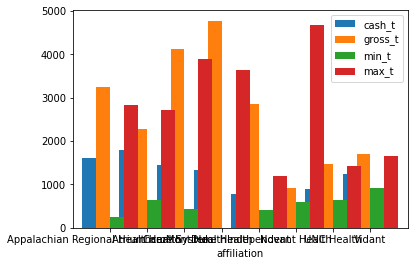

In [ ]:
means.plot.bar(x='affiliation', y=["cash_t", "gross_t", "min_t", "max_t"], rot=0, width = 1.5)

c. Feature Encoding

In [ ]:
# converting each city into an integer
enum = {}
for i in range(len(df['city'].unique())):
  enum.setdefault(df['city'].unique()[i], i)

df['city'] = df['city'].map(enum)

# converting each affiliation group into an integer
df['affiliation'] = df['affiliation'].map({ 'Independent': 0, 'CaroMont Health': 1,  'Duke Health': 2, 'Novant Health': 3,
                                           'Vidant': 4, 'FirstHealth': 5, 'HCA': 6, 'Atrium Health': 7, 
                                           'Appalachian Regional Healthcare System': 8, 'UNC Health': 9})

# dropping "vocabulary_id" and "state" columns because they're all the same value
df.drop(['vocabulary_id'], axis=1, inplace=True)
df.drop(['state'], axis=1, inplace=True)

# dropping following columns because either not relevant information or can be found from IDs
df.drop(['hospital_npi'], axis=1, inplace=True)
df.drop(['concept_code'], axis=1, inplace=True)
df.drop(['concept_name'], axis=1, inplace=True)
df.drop(['hospital_name'], axis=1, inplace=True)

# viewing the first few rows of the data
print(df.shape)
df.head()

(17011, 14)


<ipython-input-91-15db2bd44124>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city'] = df['city'].map(enum)
<ipython-input-91-15db2bd44124>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['affiliation'] = df['affiliation'].map({ 'Independent': 0, 'CaroMont Health': 1,  'Duke Health': 2, 'Novant Health': 3,
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

,index,concept_id,hospital_id,city,critical_access_ind,affiliation,cash_t,gross_t,max_t,min_t,PR_max,PR_min,PR_cash,PR_gross
0,0,40218804,10,0,0,0,74.20,106.00,97.52,67.52,0.434767,0.614092,0.556925,0.345712
1,1,40218804,41,1,0,1,63.75,182.15,173.04,23.00,0.467085,0.558941,0.546245,0.395579
2,2,40218804,48,2,0,2,39.20,140.00,106.40,0.00,0.439603,0.244800,0.517718,0.368825
3,3,40218804,49,3,0,2,39.20,140.00,103.88,0.00,0.438109,0.244800,0.517718,0.368825
4,4,40218804,50,3,0,2,39.20,140.00,226.07,0.00,0.485269,0.244800,0.517718,0.368825


In [ ]:
#removing percentile ranks
df.drop(['PR_max', 'PR_min', 'PR_cash', 'PR_gross'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


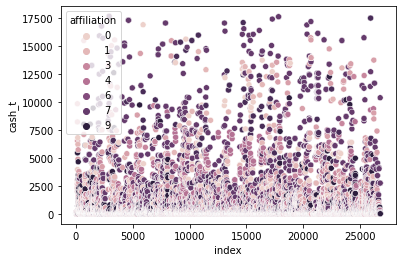

In [ ]:
#showing cash costs by affiliation
sns.scatterplot('index', 'cash_t', data=df, hue='affiliation')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


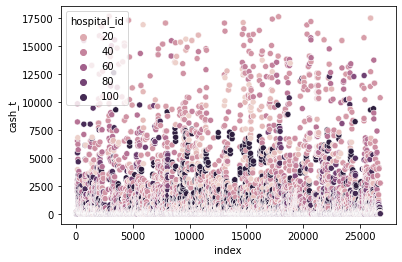

In [ ]:
#showing cash costs by hospital id
sns.scatterplot('index', 'cash_t', data=df, hue='hospital_id')
plt.show()

d. Features Correlation

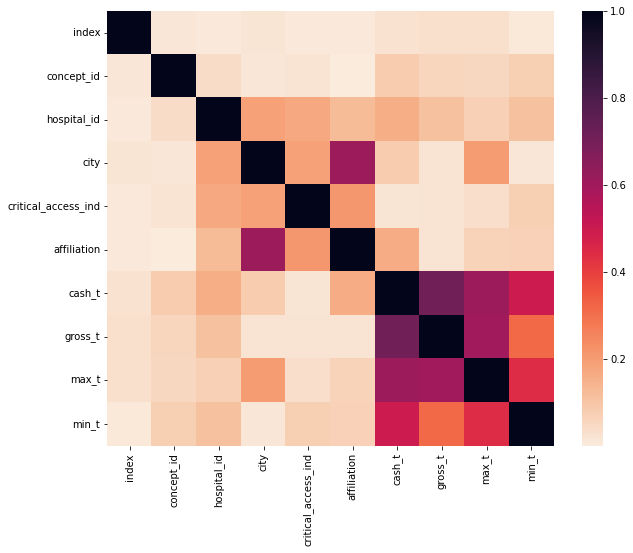

In [ ]:
# seeing how our features correlate with each other
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')

In [ ]:
# seeing how our features correlate with "gross_t"
df.corr()['gross_t'].sort_values(ascending=False)

gross_t                1.000000
cash_t                 0.710131
max_t                  0.598351
min_t                  0.313129
concept_id             0.056337
index                  0.030672
city                   0.022379
critical_access_ind    0.022347
affiliation           -0.023441
hospital_id           -0.109939
Name: gross_t, dtype: float64

In [ ]:
# seeing how our features correlate with "cash_t"
df.corr()['cash_t'].sort_values(ascending=False)

cash_t                 1.000000
gross_t                0.710131
max_t                  0.612826
min_t                  0.498768
affiliation            0.161814
concept_id             0.086167
city                   0.084458
index                  0.027374
critical_access_ind    0.017659
hospital_id           -0.159636
Name: cash_t, dtype: float64

In [ ]:
# seeing how our features correlate with "max_t"
df.corr()['max_t'].sort_values(ascending=False)

max_t                  1.000000
cash_t                 0.612826
gross_t                0.598351
min_t                  0.443984
hospital_id            0.074235
concept_id             0.054240
index                  0.028896
critical_access_ind   -0.032875
affiliation           -0.066316
city                  -0.201697
Name: max_t, dtype: float64

In [ ]:
# seeing how our features correlate with "min_t"
df.corr()['min_t'].sort_values(ascending=False)

min_t                  1.000000
cash_t                 0.498768
max_t                  0.443984
gross_t                0.313129
hospital_id            0.110809
concept_id             0.074998
affiliation            0.068775
index                  0.009390
city                  -0.015953
critical_access_ind   -0.075564
Name: min_t, dtype: float64

# Task 5: Neural Network and Regression Models

We will create a deep neural network and 2 regression models to predict the price of treatment. We are focusing on the minimum negotiated price paid for the treatment.


In [ ]:
# partitioning via a train-dev-test split
X = df.drop(['cash_t', 'gross_t', 'min_t', 'max_t', 'index'], axis=1)   # independent variables
y = df.min_t                     # dependent/target variable

# dividing the data into 'train', 'test', and 'dev' sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)          # 80% for training
#X_test, X_dev, y_test, y_dev = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)    # 10% for dev and 10% for test

# viewing the shape of each
print("x temp shape: ", X_train.shape)
print("y test shape: ", y_test.shape)

x temp shape:  (13608, 5)
y test shape:  (3403,)


In [ ]:
#scaling data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
y_train=np.reshape(y_train.values, (-1,1))
y_test=np.reshape(y_test.values, (-1,1))

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_test))
xval_scale=scaler_x.transform(X_test)
print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_test))
yval_scale=scaler_y.transform(y_test)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
#Creating deep neural network
def create_model(X):

  model = Sequential()
  model.add(Dense(X.shape[1], input_dim=X.shape[1],
                  kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.summary()

  return model

In [ ]:
deep_model = create_model(X_train)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 5)                 30        
                                                                 
 dropout_4 (Dropout)         (None, 5)                 0         
                                                                 
 dense_9 (Dense)             (None, 256)               1536      
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 67,615
Trainable params: 67,615
Non-trai

In [ ]:
#compliling model
msle = MeanSquaredLogarithmicError()
mse = MeanSquaredError()
model = create_model(X_train)
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=0.01), 
    metrics=[msle]
)
# train the model
history = model.fit(
    xtrain_scale, 
    y_train, 
    epochs=25, 
    batch_size=64,
    validation_split=0.2,
    callbacks = callbacks_list
)
     

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 5)                 30        
                                                                 
 dropout_6 (Dropout)         (None, 5)                 0         
                                                                 
 dense_13 (Dense)            (None, 256)               1536      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 67,615
Trainable params: 67,615
Non-trai

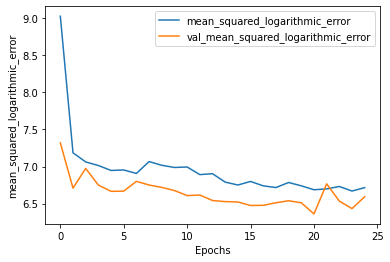

In [ ]:
def plot_metrics(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()

plot_metrics(history, 'mean_squared_logarithmic_error')

In [ ]:
#displaying metrics for the trained regression models
def model_metrics(actual, predicted, model):
  print("Metrics for {}".format(model))
  print('MAE:', metrics.mean_absolute_error(actual, predicted))  
  print('MSE:', metrics.mean_squared_error(actual, predicted))  
  print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predicted)))
  print('VarScore:',metrics.explained_variance_score(actual, predicted))
  fig = plt.figure(figsize=(10,5))
  plt.scatter(actual,predicted)


107/107 [==============================] - 0s 1ms/step
Metrics for Deep Neural Network
MAE: 617537.1516522265
MSE: 686394159144.6744
RMSE: 828489.0820914145
VarScore: -351799.6073028524


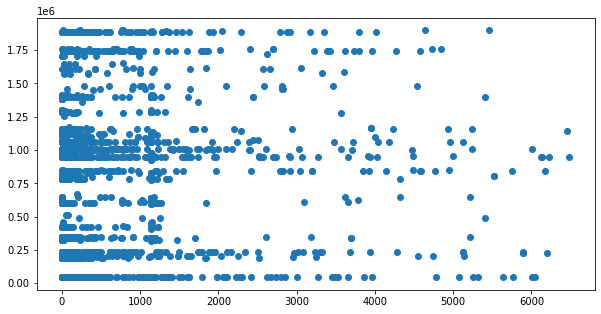

In [ ]:
#predictions
from sklearn.metrics import mean_squared_error
pred_test= (model.predict(xval_scale))
pred_test = scaler_y.inverse_transform(pred_test)
model_metrics(y_test, pred_test, "Deep Neural Network")

<ipython-input-109-855b531e42fe>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_base.fit(X_train, y_train)


Metrics for Random Forest Regressor
MAE: 315.2531930163378
MSE: 508125.52940136835
RMSE: 712.829242807398
VarScore: 0.4139861268860533


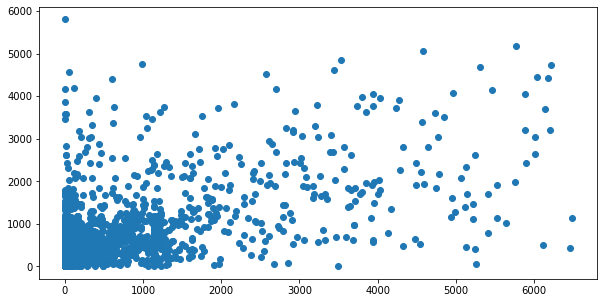

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle

# Instantiate Random Forest Regressor model with 100 decision trees
rf_base = RandomForestRegressor(n_estimators = 100, random_state = 42,oob_score = True)
rf_base.fit(X_train, y_train)


#save the model output
pickle.dump(rf_base, open("basemodel_rf", 'wb'))

#load the saved model and predict on the test data
basedmodel_rf = pickle.load(open("basemodel_rf", 'rb'))


#validate the accuracy of the base model and display metrics
Y_test_predict_base = basedmodel_rf.predict(X_test)
model_metrics(y_test, Y_test_predict_base, "Random Forest Regressor")

Metrics for XGBRegressor
MAE: 468.49561022884274
MSE: 595441.2977785288
RMSE: 771.648428870641
VarScore: 0.31343167276633566


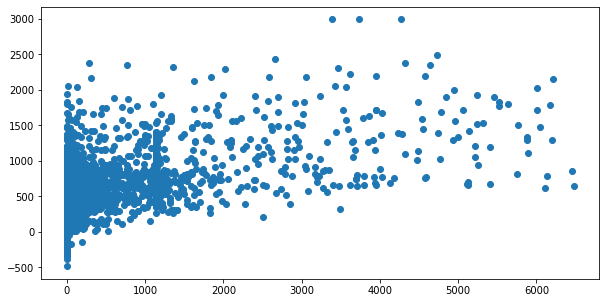

In [ ]:
from xgboost import XGBRegressor
import math
#Instantiate XG Boost Regressor Model and train on training data
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train, y_train)
#generate predictions from model
testpred = xgb_model.predict(X_test)
#display metrics for model
model_metrics(y_test, testpred, "XGBRegressor")

As seen in the displayed metrics for the models, the Random Forest Regressor had the lowest errors and the highest explained variance score of .4139. The XGB Regressor had an explained vairance score of .3134, while the neural network did not perform well.

# Task 5: Hyperparameter Tuning Random Forest Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model with cross validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

Metrics for Tuned Random Forest Regressor Model
MAE: 369.6531402771225
MSE: 545804.8124497619
RMSE: 738.786039696042
VarScore: 0.3705409827668814


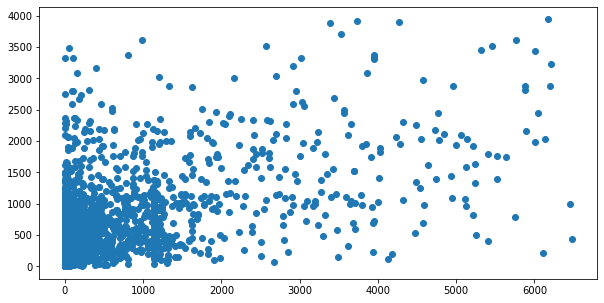

In [ ]:
tuned_predictions = grid_search.predict(X_test)
model_metrics(y_test, tuned_predictions, "Tuned Random Forest Regressor Model")

# **Conclusion**

Ultimately, the Random Forest Regressor had the best performance out of the models which were evaluated. However, even after hyperparameter tuning, the estimated variance score was .37 which demonstrates that the model is not achieving high accuracy. The performance can be attributed to these causes:


1.   **Not enough dependent variables**: Price depends heavily on the type of treatment prescribed. However, the only treatment indiciator in our data model is a treatment code and corresponding description. This does not give the model enough information beacause there are many different types of treatments.

2.   **Unclear relationship**: As seen in the EDA, there is no clear relationship between the hospitals, affiliations, and price of treatment. Therefore, it is hard for regression models to determine the exact price. 

3. **Outliers**: In the pre-processing, outlier expensive treatments were removed from the dataset. However, since there is a wide range of price values, errors are maginified when the model is not as accurate in its predictions. Furthermore, we had to remove a significant amount of hospital data since it had prices missing.

From our EDA and model results, we can determine that just using hospital data (hospital id, affiliation, city, critical access index) is not enough granularity to be able to predict pricing. Furthermore, prices seem to be distributed evenly among hospitals as no hospitals in NC are charging substantially more than others, except for a few outlying treatments. Finally, the poor DNN performance can be attributed to the above reasons as well as a lack of a large dataset necessary for training an accurate DNN



## Possible Next Steps



1.   Natural Language Processing on Concepts - to classify and create more features from treatment information
2.  More extensive hospital data - including states other than North Carolina
3.  Narrow dataset on specific treatments and conditions to determine price disparitites between hospitals and relations between conditiona and price
4. Including insurance information - which payer was responsible for negotiating prices





